# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [1]:
import os
import time

# wait_to_make = "trained_list/mpnet-base-trans.txt"
# count = 0
# while 1:
#     if os.path.exists(wait_to_make):
#         break
#     print(f'sleep {count} h')
#     time.sleep(3600)
#     count+=1
    


In [2]:
_mixout = 0.9
EXP_NAME = f"microsoft-deberta-large-bcewithlogloss-mse"


In [3]:
# !nvidia-smi
# !pip install torch==1.10
! pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [4]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================

import os
import datetime

INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'
dt_now = datetime.datetime.now()

date = dt_now.strftime('%Y-%m-%d-%H-%M-%S')
 
OUTPUT_DIR = f'./output/{EXP_NAME}/'
# if not os.path.exists(OUTPUT_DIR):
os.makedirs(OUTPUT_DIR, exist_ok=True)


# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    EXP_NAME= EXP_NAME
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-large"
    # model = "microsoft/deberta-large"
    # size = "large
    # model = f"{model}-{size}"
    if "small" in model:
        hidden_state = hiddden_state_fix = 512
    elif "base" in model:
        hidden_state = hiddden_state_fix = 768
    elif "large" in model:
        hidden_state = hiddden_state_fix = 1024
    elif "xlarge" in model:
        hidden_state =  1536
        
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=6
    encoder_lr=3e-5
    decoder_lr=3e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    
    batch_size=8
    mixout = True
    mixout_prob = _mixout
    pass_fold = [None]
    hidden_size = 512
    
    
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[i for i in range(n_fold)]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [7]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

In [8]:
# !pip install transformers==4.16.2
# !pip install tokenizers==0.11.0

# Library

In [9]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig,AutoModelForTokenClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

start = time.time()

torch.__version__: 1.9.0+cu111
tokenizers.__version__: 0.11.6
transformers.__version__: 4.17.0
env: TOKENIZERS_PARALLELISM=true
cuda


# Utils

In [10]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    if os.path.exists(filename):
        os.remove(filename)
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [11]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [12]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir(INPUT_DIR+'CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'{INPUT_DIR}CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


# cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
cpc_texts = torch.load(INPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [13]:
pad = "[SEP]"
train['text'] = train['anchor'] + pad + train['target'] +pad  + train['context_text']
test['text'] = test['anchor'] + pad + test['target'] +pad  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

<AxesSubplot:>

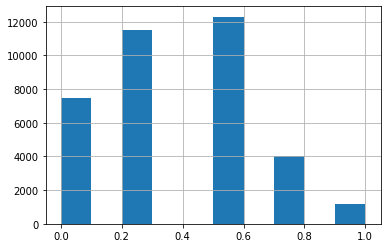

In [14]:
train['score'].hist()

In [15]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [16]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [17]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [18]:
# !pip install --no-cache-dir sentencepiece

In [19]:
# ====================================================
# tokenizer
# ====================================================
# tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [20]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [21]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

sys.path.append('../dataset')
from dataset import TrainDataset

torch.__version__: 1.9.0+cu111


In [22]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [23]:
# class CustomModel(nn.Module):#cat dim=1
#     def __init__(self, cfg, config_path=None, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
#         # self.use_last_hidden_num = 3
#         self.use_last_hidden_num = 1
#         self.weight = nn.Softmax()(torch.tensor(torch.randn(self.use_last_hidden_num))).to(device)

#         # self.weight = nn.Softmax()(torch.tensor([1./self.use_last_hidden_num for _ in range(self.use_last_hidden_num)])).to(device)
#         self.weight = torch.autograd.Variable(self.weight,  requires_grad=True)
#         if config_path is None:
#             self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
#         else:
#             self.config = torch.load(config_path)
#         if pretrained:
#             self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
#         else:
#             self.model = AutoModel.from_config(self.config)
#         self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        
#         self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
#         self._init_weights(self.fc)
#         self.attention = nn.Sequential(
#             nn.Linear(self.config.hidden_size, 512),
#             nn.Tanh(),
#             nn.Linear(512, 1),
#             nn.Softmax(dim=1)
#         )
#         self._init_weights(self.attention)
#         # for i in range(1, self.use_last_hidden_num+1):
#         #     setattr(self, f"fc_{i}", nn.Linear(self.config.hidden_size, self.config.hidden_size))
            
#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
        
#     def feature(self, inputs):
#         outputs = self.model(**inputs)
#         last_hidden_states = []
#         # for i in range(1, self.use_last_hidden_num+1):
#         #     h = getattr(self, f"fc_{i}")
#         #     last_hidden_states.append(h(torch.tensor(outputs["hidden_states"][-1*i]).unsqueeze(1)))
                                      
#         # last_hidden_states = torch.cat(last_hidden_states, dim=1)
#         # last_hidden_states = torch.mean(last_hidden_states, dim=1)
#         # self.weight = nn.Softmax()(self.weight)
#         # self.weight = torch.autograd.Variable(self.weight,  requires_grad=True)
#         last_hidden_states = torch.cat([torch.tensor(outputs["hidden_states"][-1*i].unsqueeze(1))*self.weight[i-1] for i in range(1, self.use_last_hidden_num+1)],dim=1)
#         last_hidden_states = torch.mean(last_hidden_states, dim=1)
        
#         weights = self.attention(last_hidden_states)
#         feature = torch.sum(weights * last_hidden_states, dim=1)
#         return feature

#     def forward(self, inputs):
#         feature = self.feature(inputs)
#         output = self.fc(self.fc_dropout(feature))
#         # output = self.cnn(feature)
#         return output


In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        
        # self.cnn = oneDCNN(self.config.hidden_size, self.cfg.target_size, cfg.hidden_size, cfg=cfg)
        # self._init_weights(self.cnn)
        
        # self.lstm = nn.Sequential(
        #     nn.LSTM(self.config.hidden_size, cfg.hidden_size, batch_first=True),
        # )
        # self.lstmfc = nn.Linear(cfg.hidden_size, 1)
        
        # self._init_weights(self.lstm)
        
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        # last_hidden_states = outputs[0]
        last_hidden_states = outputs["last_hidden_state"]#.permute(0, 2, 1)
        
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        
        output = self.fc(self.fc_dropout(feature))
        return output

In [25]:
# class CustomModel(nn.Module):
#     def __init__(self, cfg, config_path=None, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
#         if config_path is None:
#             self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
#         else:
#             self.config = torch.load(config_path)
#         if pretrained:
#             self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
#             token_embeddings_size = len(CFG.tokenizer)
#             self.model.resize_token_embeddings(token_embeddings_size)
#         else:
#             self.model = AutoModel.from_config(self.config)

#         self.fc_dropout1 = nn.Dropout(0.1)
#         self.fc_dropout2 = nn.Dropout(0.2)
#         self.fc_dropout3 = nn.Dropout(0.3)
#         self.fc_dropout4 = nn.Dropout(0.4)
#         self.fc_dropout5 = nn.Dropout(0.5)

#         self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
#         self._init_weights(self.fc)
#         # これがいわゆるattention pool
#         # https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/discussion/324330
#         self.attention = nn.Sequential(
#             nn.Linear(self.config.hidden_size, self.config.hidden_size),
#             nn.LayerNorm(self.config.hidden_size),
#             nn.GELU(),
#             nn.Linear(self.config.hidden_size, 1),
#             nn.Softmax(dim=1)
#         )
#         self._init_weights(self.attention)
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
        
#     def feature(self, inputs):
#         outputs = self.model(**inputs)
#         last_hidden_states = outputs[0]
#         # feature = torch.mean(last_hidden_states, 1)
#         weights = self.attention(last_hidden_states)
#         feature = torch.sum(weights * last_hidden_states, dim=1)
#         return feature

#     def forward(self, inputs):
#         feature = self.feature(inputs)

#         feature1 = self.fc_dropout1(feature)
#         feature2 = self.fc_dropout2(feature)
#         feature3 = self.fc_dropout3(feature)
#         feature4 = self.fc_dropout4(feature)
#         feature5 = self.fc_dropout5(feature)

#         feature_all = (feature1+feature2+feature3+feature4+feature5)/5
#         output = self.fc(feature_all)
        
#         return output

# Helpler functions

In [26]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if "train" in EXP_NAME:
        for sup_module in model.modules():
            for name, module in sup_module.named_children():
                if isinstance(module, nn.Dropout):
                    module.p = 0.0
                if isinstance(module, nn.Linear):
                    target_state_dict = module.state_dict()
                    bias = True if module.bias is not None else False
                    new_module = MixLinear(
                        module.in_features, module.out_features, bias, target_state_dict["weight"], CFG.mixout_prob
                    )
                    new_module.load_state_dict(target_state_dict)
                    setattr(sup_module, name, new_module)

        model.to(device)                
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    
    criterion0 = nn.BCEWithLogitsLoss(reduction="mean")
    criterion1 = nn.MSELoss(reduction='mean')
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        # loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        with torch.cuda.amp.autocast():
            loss0 = criterion0(y_preds.view(-1, 1), labels.view(-1, 1))
            loss1 = criterion1(y_preds.view(-1, 1), labels.view(-1, 1))

        # (retain_graph here is unrelated to amp, it's present because in this
        # example, both backward() calls share some sections of graph.)
        scaler.scale(loss0).backward(retain_graph=True)
        scaler.scale(loss1).backward()
        loss = loss0 + loss1
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        # scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))#+ f"weight: {model.weight}")
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    criterion0 = nn.BCEWithLogitsLoss(reduction="mean")
    criterion1 = nn.MSELoss(reduction='mean')
    
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
            loss0 = criterion0(y_preds.view(-1, 1), labels.view(-1, 1))
            loss1 = criterion1(y_preds.view(-1, 1), labels.view(-1, 1))
        loss = loss0 + loss1    
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [27]:
# ====================================================
# train loop
# ====================================================
# def train_loop(folds, fold):
def train_loop(train_loader, valid_loader):

    # ====================================================
    # model & optimizer
    # ====================================================
    if "transformer" in EXP_NAME:
        model = CustomModelTransformer(CFG, config_path=None, pretrained=True)
    else:
        model = CustomModel(CFG, config_path=None, pretrained=True)
    if "all" in EXP_NAME:
        for sup_module in model.modules():
            for name, module in sup_module.named_children():
                if isinstance(module, nn.Dropout):
                    module.p = 0.0
                if isinstance(module, nn.Linear):
                    target_state_dict = module.state_dict()
                    bias = True if module.bias is not None else False
                    new_module = MixLinear(
                        module.in_features, module.out_features, bias, target_state_dict["weight"], CFG.mixout_prob
                    )
                    new_module.load_state_dict(target_state_dict)
                    setattr(sup_module, name, new_module)
    model.to(device)
                
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0},
            # {"params" : model.weight, "lr":encoder_lr, "weight_decay":0.0},
            
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    # criterion = nn.BCEWithLogitsLoss(reduction="mean")
    criterion = nn.MSELoss(reduction='mean')
    
    best_score = 0.

    for epoch in range(CFG.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()

    
    return valid_folds

In [28]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.pass_fold:continue
            LOGGER.info(f"========== fold: {fold} training ==========")
            print(f"\033[38;5;40m========== fold: {fold} training ==========\033[0m");
            if fold in CFG.trn_fold:
                # ====================================================
                # loader
                # ====================================================
                folds = train
                train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
                valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
                valid_labels = valid_folds['score'].values

                train_dataset = TrainDataset(CFG, train_folds)
                valid_dataset = TrainDataset(CFG, valid_folds)

                train_loader = DataLoader(train_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=True,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
                valid_loader = DataLoader(valid_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=False,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

#                 _oof_df = train_loop(train, fold)
                _oof_df = train_loop(train_loader, valid_loader)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


========== fold: 0 training ==========


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3419] Elapsed 0m 0s (remain 50m 41s) Loss: 1.1987(1.1987) Grad: inf  LR: 0.00003000  
Epoch: [1][100/3419] Elapsed 1m 20s (remain 44m 1s) Loss: 0.8719(0.8623) Grad: 39107.1641  LR: 0.00003000  
Epoch: [1][200/3419] Elapsed 2m 38s (remain 42m 17s) Loss: 0.7926(0.8260) Grad: 22164.8418  LR: 0.00002999  
Epoch: [1][300/3419] Elapsed 3m 55s (remain 40m 37s) Loss: 0.7398(0.8091) Grad: 13801.2324  LR: 0.00002998  
Epoch: [1][400/3419] Elapsed 5m 12s (remain 39m 11s) Loss: 0.7630(0.7988) Grad: 7875.1724  LR: 0.00002997  
Epoch: [1][500/3419] Elapsed 6m 29s (remain 37m 49s) Loss: 0.7609(0.7928) Grad: 20792.3516  LR: 0.00002996  
Epoch: [1][600/3419] Elapsed 7m 47s (remain 36m 33s) Loss: 0.7644(0.7880) Grad: 21217.1270  LR: 0.00002994  
Epoch: [1][700/3419] Elapsed 9m 4s (remain 35m 12s) Loss: 0.7063(0.7826) Grad: 20783.5391  LR: 0.00002991  
Epoch: [1][800/3419] Elapsed 10m 16s (remain 33m 34s) Loss: 0.7773(0.7791) Grad: 29184.5078  LR: 0.00002989  
Epoch: [1][900/3419] Elapsed 11

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 38s) Loss: 0.8423(0.8423) 
EVAL: [100/1140] Elapsed 0m 15s (remain 2m 36s) Loss: 0.8236(0.8200) 
EVAL: [200/1140] Elapsed 0m 30s (remain 2m 21s) Loss: 0.8785(0.8196) 
EVAL: [300/1140] Elapsed 0m 45s (remain 2m 5s) Loss: 0.7616(0.8173) 
EVAL: [400/1140] Elapsed 1m 0s (remain 1m 50s) Loss: 0.8297(0.8162) 
EVAL: [500/1140] Elapsed 1m 14s (remain 1m 35s) Loss: 0.7940(0.8155) 
EVAL: [600/1140] Elapsed 1m 29s (remain 1m 20s) Loss: 0.8110(0.8169) 
EVAL: [700/1140] Elapsed 1m 43s (remain 1m 4s) Loss: 0.7971(0.8166) 
EVAL: [800/1140] Elapsed 1m 57s (remain 0m 49s) Loss: 0.7629(0.8171) 
EVAL: [900/1140] Elapsed 2m 10s (remain 0m 34s) Loss: 0.8582(0.8168) 
EVAL: [1000/1140] Elapsed 2m 24s (remain 0m 20s) Loss: 0.8240(0.8166) 
EVAL: [1100/1140] Elapsed 2m 38s (remain 0m 5s) Loss: 0.8356(0.8167) 


Epoch 1 - avg_train_loss: 0.7829  avg_val_loss: 0.8168  time: 2597s
Epoch 1 - Score: 0.1518
Epoch 1 - Save Best Score: 0.1518 Model


EVAL: [1139/1140] Elapsed 2m 44s (remain 0m 0s) Loss: 0.7819(0.8168) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 46m 26s) Loss: 0.8486(0.8486) Grad: 89168.9531  LR: 0.00002799  
Epoch: [2][100/3419] Elapsed 1m 3s (remain 34m 41s) Loss: 0.8530(0.8092) Grad: 62571.7227  LR: 0.00002787  
Epoch: [2][200/3419] Elapsed 2m 6s (remain 33m 38s) Loss: 0.7964(0.7979) Grad: 65822.5938  LR: 0.00002775  
Epoch: [2][300/3419] Elapsed 3m 8s (remain 32m 34s) Loss: 0.7097(0.7875) Grad: 59915.4023  LR: 0.00002763  
Epoch: [2][400/3419] Elapsed 4m 11s (remain 31m 32s) Loss: 0.6996(0.7751) Grad: 18433.9160  LR: 0.00002751  
Epoch: [2][500/3419] Elapsed 5m 14s (remain 30m 29s) Loss: 0.7953(0.7668) Grad: 29905.6953  LR: 0.00002738  
Epoch: [2][600/3419] Elapsed 6m 16s (remain 29m 27s) Loss: 0.6821(0.7602) Grad: 47450.2969  LR: 0.00002725  
Epoch: [2][700/3419] Elapsed 7m 19s (remain 28m 24s) Loss: 0.7535(0.7561) Grad: 29890.1699  LR: 0.00002711  
Epoch: [2][800/3419] Elapsed 8m 22s (remain 27m 22s) Loss: 0.7481(0.7538) Grad: 25241.7441  LR: 0.00002698  
Epoch: [2][900/3419] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 14s) Loss: 0.7430(0.7430) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.7819(0.7371) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.7661(0.7334) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.7825(0.7303) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.6510(0.7287) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.7301(0.7306) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.7171(0.7308) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 0s) Loss: 0.7443(0.7308) 
EVAL: [800/1140] Elapsed 1m 51s (remain 0m 46s) Loss: 0.7685(0.7314) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.6990(0.7303) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.6764(0.7302) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.7184(0.7296) 


Epoch 2 - avg_train_loss: 0.7291  avg_val_loss: 0.7296  time: 2305s
Epoch 2 - Score: 0.8423
Epoch 2 - Save Best Score: 0.8423 Model


EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.6456(0.7296) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 52m 55s) Loss: 0.7002(0.7002) Grad: 52563.7617  LR: 0.00002250  
Epoch: [3][100/3419] Elapsed 1m 3s (remain 34m 49s) Loss: 0.7123(0.7091) Grad: 11584.4189  LR: 0.00002230  
Epoch: [3][200/3419] Elapsed 2m 6s (remain 33m 42s) Loss: 0.7231(0.7057) Grad: 63564.4102  LR: 0.00002210  
Epoch: [3][300/3419] Elapsed 3m 9s (remain 32m 38s) Loss: 0.7115(0.7047) Grad: 45607.2930  LR: 0.00002189  
Epoch: [3][400/3419] Elapsed 4m 11s (remain 31m 35s) Loss: 0.7153(0.7044) Grad: 130002.1719  LR: 0.00002169  
Epoch: [3][500/3419] Elapsed 5m 14s (remain 30m 31s) Loss: 0.6695(0.7046) Grad: 60315.4180  LR: 0.00002148  
Epoch: [3][600/3419] Elapsed 6m 17s (remain 29m 28s) Loss: 0.6545(0.7049) Grad: 51005.3633  LR: 0.00002128  
Epoch: [3][700/3419] Elapsed 7m 19s (remain 28m 25s) Loss: 0.7750(0.7050) Grad: 78545.4922  LR: 0.00002107  
Epoch: [3][800/3419] Elapsed 8m 22s (remain 27m 23s) Loss: 0.7126(0.7050) Grad: 59382.2344  LR: 0.00002085  
Epoch: [3][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][3418/3419] Elapsed 35m 44s (remain 0m 0s) Loss: 0.7477(0.7046) Grad: 80846.9688  LR: 0.00001500  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 19s) Loss: 0.7181(0.7181) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.7530(0.7273) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.7714(0.7264) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.7604(0.7223) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.6580(0.7207) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.7208(0.7222) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.7157(0.7227) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 0s) Loss: 0.7372(0.7226) 
EVAL: [800/1140] Elapsed 1m 51s (remain 0m 47s) Loss: 0.7563(0.7229) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.6974(0.7219) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.6811(0.7221) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.7004(0.7216) 


Epoch 3 - avg_train_loss: 0.7046  avg_val_loss: 0.7216  time: 2303s
Epoch 3 - Score: 0.8559
Epoch 3 - Save Best Score: 0.8559 Model


EVAL: [1139/1140] Elapsed 2m 38s (remain 0m 0s) Loss: 0.6431(0.7216) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 54m 11s) Loss: 0.6680(0.6680) Grad: 41056.4805  LR: 0.00001500  
Epoch: [4][100/3419] Elapsed 1m 3s (remain 34m 51s) Loss: 0.7086(0.6913) Grad: 39732.3242  LR: 0.00001477  
Epoch: [4][200/3419] Elapsed 2m 6s (remain 33m 44s) Loss: 0.7490(0.6925) Grad: 73347.5781  LR: 0.00001454  
Epoch: [4][300/3419] Elapsed 3m 9s (remain 32m 46s) Loss: 0.6937(0.6953) Grad: 47169.8789  LR: 0.00001431  
Epoch: [4][400/3419] Elapsed 4m 12s (remain 31m 41s) Loss: 0.7160(0.6953) Grad: 34210.7930  LR: 0.00001408  
Epoch: [4][500/3419] Elapsed 5m 15s (remain 30m 36s) Loss: 0.7423(0.6954) Grad: 63231.8711  LR: 0.00001385  
Epoch: [4][600/3419] Elapsed 6m 18s (remain 29m 33s) Loss: 0.6854(0.6955) Grad: 49154.3594  LR: 0.00001362  
Epoch: [4][700/3419] Elapsed 7m 20s (remain 28m 29s) Loss: 0.7068(0.6958) Grad: 37177.2383  LR: 0.00001339  
Epoch: [4][800/3419] Elapsed 8m 23s (remain 27m 26s) Loss: 0.7195(0.6961) Grad: 20350.2246  LR: 0.00001317  
Epoch: [4][900/3419] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 22s) Loss: 0.7283(0.7283) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.7653(0.7286) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 10s) Loss: 0.7684(0.7284) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.7903(0.7247) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.6840(0.7222) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.7215(0.7233) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.7133(0.7236) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 0s) Loss: 0.7318(0.7237) 
EVAL: [800/1140] Elapsed 1m 51s (remain 0m 47s) Loss: 0.7586(0.7239) 
EVAL: [900/1140] Elapsed 2m 5s (remain 0m 33s) Loss: 0.6974(0.7232) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.6804(0.7235) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.6875(0.7230) 


Epoch 4 - avg_train_loss: 0.6976  avg_val_loss: 0.7230  time: 2305s
Epoch 4 - Score: 0.8595
Epoch 4 - Save Best Score: 0.8595 Model


EVAL: [1139/1140] Elapsed 2m 38s (remain 0m 0s) Loss: 0.6455(0.7230) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 51m 23s) Loss: 0.7088(0.7088) Grad: 24002.1973  LR: 0.00000750  
Epoch: [5][100/3419] Elapsed 1m 3s (remain 34m 50s) Loss: 0.6929(0.6932) Grad: 68487.1094  LR: 0.00000730  
Epoch: [5][200/3419] Elapsed 2m 6s (remain 33m 43s) Loss: 0.7535(0.6953) Grad: 138961.9062  LR: 0.00000711  
Epoch: [5][300/3419] Elapsed 3m 9s (remain 32m 39s) Loss: 0.6647(0.6934) Grad: 13162.8115  LR: 0.00000691  
Epoch: [5][400/3419] Elapsed 4m 11s (remain 31m 35s) Loss: 0.7156(0.6920) Grad: 28613.0488  LR: 0.00000672  
Epoch: [5][500/3419] Elapsed 5m 14s (remain 30m 32s) Loss: 0.7097(0.6926) Grad: 40910.9648  LR: 0.00000653  
Epoch: [5][600/3419] Elapsed 6m 17s (remain 29m 29s) Loss: 0.6655(0.6921) Grad: 50734.4062  LR: 0.00000634  
Epoch: [5][700/3419] Elapsed 7m 20s (remain 28m 26s) Loss: 0.7062(0.6920) Grad: 95473.8750  LR: 0.00000615  
Epoch: [5][800/3419] Elapsed 8m 22s (remain 27m 23s) Loss: 0.5997(0.6914) Grad: 123884.9688  LR: 0.00000597  
Epoch: [5][900/3419] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 16s) Loss: 0.7281(0.7281) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.7633(0.7260) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.7616(0.7259) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.7784(0.7223) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.6793(0.7202) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.7225(0.7213) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.7127(0.7217) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 0s) Loss: 0.7331(0.7216) 
EVAL: [800/1140] Elapsed 1m 51s (remain 0m 47s) Loss: 0.7538(0.7220) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.6971(0.7213) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.6864(0.7215) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.6831(0.7209) 


Epoch 5 - avg_train_loss: 0.6931  avg_val_loss: 0.7210  time: 2304s
Epoch 5 - Score: 0.8588


EVAL: [1139/1140] Elapsed 2m 38s (remain 0m 0s) Loss: 0.6427(0.7210) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 37m 35s) Loss: 0.7189(0.7189) Grad: 13078.6025  LR: 0.00000201  
Epoch: [6][100/3419] Elapsed 1m 3s (remain 34m 43s) Loss: 0.6966(0.6924) Grad: 25639.2266  LR: 0.00000190  
Epoch: [6][200/3419] Elapsed 2m 6s (remain 33m 39s) Loss: 0.7165(0.6896) Grad: 83858.2812  LR: 0.00000179  
Epoch: [6][300/3419] Elapsed 3m 8s (remain 32m 36s) Loss: 0.7060(0.6896) Grad: 13291.9102  LR: 0.00000168  
Epoch: [6][400/3419] Elapsed 4m 11s (remain 31m 34s) Loss: 0.7430(0.6884) Grad: 121259.5938  LR: 0.00000157  
Epoch: [6][500/3419] Elapsed 5m 14s (remain 30m 31s) Loss: 0.6694(0.6888) Grad: 19309.8574  LR: 0.00000147  
Epoch: [6][600/3419] Elapsed 6m 17s (remain 29m 28s) Loss: 0.7254(0.6896) Grad: 62252.5703  LR: 0.00000138  
Epoch: [6][700/3419] Elapsed 7m 19s (remain 28m 25s) Loss: 0.6676(0.6900) Grad: 16365.5146  LR: 0.00000128  
Epoch: [6][800/3419] Elapsed 8m 22s (remain 27m 22s) Loss: 0.7090(0.6901) Grad: 48147.7930  LR: 0.00000119  
Epoch: [6][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 44s) Loss: 0.7265(0.7265) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.7674(0.7275) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.7666(0.7273) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.7899(0.7238) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.6785(0.7215) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.7219(0.7227) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.7154(0.7231) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 0s) Loss: 0.7322(0.7231) 
EVAL: [800/1140] Elapsed 1m 51s (remain 0m 47s) Loss: 0.7547(0.7234) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.6987(0.7227) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.6890(0.7230) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.6838(0.7223) 


Epoch 6 - avg_train_loss: 0.6907  avg_val_loss: 0.7224  time: 2303s
Epoch 6 - Score: 0.8583


EVAL: [1139/1140] Elapsed 2m 38s (remain 0m 0s) Loss: 0.6440(0.7224) 


========== fold: 0 result ==========
Score: 0.8595
========== fold: 1 training ==========


========== fold: 1 training ==========


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.c

Epoch: [1][0/3419] Elapsed 0m 0s (remain 54m 50s) Loss: 3.0296(3.0296) Grad: inf  LR: 0.00003000  
Epoch: [1][100/3419] Elapsed 1m 3s (remain 34m 36s) Loss: 0.7633(0.9950) Grad: 7396.2480  LR: 0.00003000  
Epoch: [1][200/3419] Elapsed 2m 5s (remain 33m 36s) Loss: 0.7227(0.9013) Grad: 4752.6538  LR: 0.00002999  
Epoch: [1][300/3419] Elapsed 3m 8s (remain 32m 35s) Loss: 0.7668(0.8603) Grad: 4758.0410  LR: 0.00002998  
Epoch: [1][400/3419] Elapsed 4m 11s (remain 31m 32s) Loss: 0.7209(0.8362) Grad: 7617.3560  LR: 0.00002997  
Epoch: [1][500/3419] Elapsed 5m 14s (remain 30m 30s) Loss: 0.7495(0.8192) Grad: 5663.0337  LR: 0.00002996  
Epoch: [1][600/3419] Elapsed 6m 17s (remain 29m 27s) Loss: 0.7320(0.8106) Grad: 4084.6663  LR: 0.00002994  
Epoch: [1][700/3419] Elapsed 7m 19s (remain 28m 25s) Loss: 0.7253(0.8026) Grad: 5322.8101  LR: 0.00002991  
Epoch: [1][800/3419] Elapsed 8m 22s (remain 27m 22s) Loss: 0.7539(0.7964) Grad: 1425.3030  LR: 0.00002989  
Epoch: [1][900/3419] Elapsed 9m 25s (rem

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 57s) Loss: 0.7651(0.7651) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.7222(0.7254) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.7236(0.7314) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.7536(0.7302) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.6954(0.7295) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.6881(0.7305) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.6732(0.7299) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 0s) Loss: 0.7374(0.7314) 
EVAL: [800/1140] Elapsed 1m 51s (remain 0m 47s) Loss: 0.8474(0.7307) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.6789(0.7296) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.7813(0.7289) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.6297(0.7279) 


Epoch 1 - avg_train_loss: 0.7522  avg_val_loss: 0.7281  time: 2304s
Epoch 1 - Score: 0.8253
Epoch 1 - Save Best Score: 0.8253 Model


EVAL: [1139/1140] Elapsed 2m 38s (remain 0m 0s) Loss: 0.8409(0.7281) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 1s (remain 58m 18s) Loss: 0.6784(0.6784) Grad: 45552.7227  LR: 0.00002799  
Epoch: [2][100/3419] Elapsed 1m 3s (remain 34m 52s) Loss: 0.7269(0.7135) Grad: 225296.1875  LR: 0.00002787  
Epoch: [2][200/3419] Elapsed 2m 6s (remain 33m 44s) Loss: 0.6431(0.7119) Grad: 35864.0625  LR: 0.00002775  
Epoch: [2][300/3419] Elapsed 3m 9s (remain 32m 40s) Loss: 0.6613(0.7122) Grad: 25982.8477  LR: 0.00002763  
Epoch: [2][400/3419] Elapsed 4m 11s (remain 31m 36s) Loss: 0.6895(0.7131) Grad: 32084.4629  LR: 0.00002751  
Epoch: [2][500/3419] Elapsed 5m 14s (remain 30m 33s) Loss: 0.7301(0.7144) Grad: 39788.8281  LR: 0.00002738  
Epoch: [2][600/3419] Elapsed 6m 17s (remain 29m 30s) Loss: 0.6973(0.7149) Grad: 48127.0859  LR: 0.00002725  
Epoch: [2][700/3419] Elapsed 7m 20s (remain 28m 27s) Loss: 0.7084(0.7145) Grad: 124836.1406  LR: 0.00002711  
Epoch: [2][800/3419] Elapsed 8m 23s (remain 27m 24s) Loss: 0.7407(0.7141) Grad: 58109.7852  LR: 0.00002698  
Epoch: [2][900/3419] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][3418/3419] Elapsed 39m 5s (remain 0m 0s) Loss: 0.6345(0.7114) Grad: 35015.8516  LR: 0.00002250  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 12s) Loss: 0.7164(0.7164) 
EVAL: [100/1140] Elapsed 0m 15s (remain 2m 36s) Loss: 0.7184(0.7146) 
EVAL: [200/1140] Elapsed 0m 30s (remain 2m 20s) Loss: 0.7254(0.7184) 
EVAL: [300/1140] Elapsed 0m 44s (remain 2m 5s) Loss: 0.7504(0.7205) 
EVAL: [400/1140] Elapsed 0m 59s (remain 1m 50s) Loss: 0.7033(0.7203) 
EVAL: [500/1140] Elapsed 1m 14s (remain 1m 35s) Loss: 0.7092(0.7213) 
EVAL: [600/1140] Elapsed 1m 29s (remain 1m 20s) Loss: 0.6626(0.7210) 
EVAL: [700/1140] Elapsed 1m 44s (remain 1m 5s) Loss: 0.7274(0.7221) 
EVAL: [800/1140] Elapsed 1m 59s (remain 0m 50s) Loss: 0.8169(0.7213) 
EVAL: [900/1140] Elapsed 2m 14s (remain 0m 35s) Loss: 0.6356(0.7203) 
EVAL: [1000/1140] Elapsed 2m 29s (remain 0m 20s) Loss: 0.8033(0.7196) 
EVAL: [1100/1140] Elapsed 2m 44s (remain 0m 5s) Loss: 0.6209(0.7188) 


Epoch 2 - avg_train_loss: 0.7114  avg_val_loss: 0.7189  time: 2516s
Epoch 2 - Score: 0.8524
Epoch 2 - Save Best Score: 0.8524 Model


EVAL: [1139/1140] Elapsed 2m 50s (remain 0m 0s) Loss: 0.7542(0.7189) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 56m 8s) Loss: 0.6968(0.6968) Grad: 47445.3672  LR: 0.00002250  
Epoch: [3][100/3419] Elapsed 1m 11s (remain 39m 4s) Loss: 0.6962(0.7065) Grad: 49989.4766  LR: 0.00002230  
Epoch: [3][200/3419] Elapsed 2m 21s (remain 37m 52s) Loss: 0.7547(0.7051) Grad: 53483.1055  LR: 0.00002210  
Epoch: [3][300/3419] Elapsed 3m 32s (remain 36m 40s) Loss: 0.6350(0.7056) Grad: 42705.6016  LR: 0.00002189  
Epoch: [3][400/3419] Elapsed 4m 39s (remain 35m 4s) Loss: 0.7032(0.7061) Grad: 31891.7207  LR: 0.00002169  
Epoch: [3][500/3419] Elapsed 5m 42s (remain 33m 14s) Loss: 0.7215(0.7063) Grad: 34217.3281  LR: 0.00002148  
Epoch: [3][600/3419] Elapsed 6m 45s (remain 31m 40s) Loss: 0.7194(0.7062) Grad: 34627.2344  LR: 0.00002128  
Epoch: [3][700/3419] Elapsed 7m 48s (remain 30m 14s) Loss: 0.7141(0.7065) Grad: 43613.3047  LR: 0.00002107  
Epoch: [3][800/3419] Elapsed 8m 50s (remain 28m 54s) Loss: 0.7207(0.7056) Grad: 33594.6406  LR: 0.00002086  
Epoch: [3][900/3419] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 14s) Loss: 0.7194(0.7194) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.7234(0.7200) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 11s) Loss: 0.7222(0.7233) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.7554(0.7243) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.7016(0.7247) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.6947(0.7258) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.6649(0.7259) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 1s) Loss: 0.7460(0.7274) 
EVAL: [800/1140] Elapsed 1m 51s (remain 0m 47s) Loss: 0.8658(0.7267) 
EVAL: [900/1140] Elapsed 2m 5s (remain 0m 33s) Loss: 0.6305(0.7258) 
EVAL: [1000/1140] Elapsed 2m 19s (remain 0m 19s) Loss: 0.8388(0.7252) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.6306(0.7245) 
EVAL: [1139/1140] Elapsed 2m 38s (remain 0m 0s) Loss: 0.8026(0.7245) 


Epoch 3 - avg_train_loss: 0.7052  avg_val_loss: 0.7245  time: 2371s
Epoch 3 - Score: 0.8523
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 40m 33s) Loss: 0.6760(0.6760) Grad: 32947.0586  LR: 0.00001500  
Epoch: [4][100/3419] Elapsed 1m 3s (remain 34m 49s) Loss: 0.7256(0.7004) Grad: 166055.5469  LR: 0.00001477  
Epoch: [4][200/3419] Elapsed 2m 6s (remain 33m 45s) Loss: 0.6993(0.6975) Grad: 95890.6250  LR: 0.00001454  
Epoch: [4][300/3419] Elapsed 3m 9s (remain 32m 41s) Loss: 0.7026(0.6992) Grad: 70297.7656  LR: 0.00001431  
Epoch: [4][400/3419] Elapsed 4m 12s (remain 31m 38s) Loss: 0.7278(0.6989) Grad: 61753.5820  LR: 0.00001408  
Epoch: [4][500/3419] Elapsed 5m 15s (remain 30m 35s) Loss: 0.6829(0.6989) Grad: 39323.0273  LR: 0.00001385  
Epoch: [4][600/3419] Elapsed 6m 18s (remain 29m 32s) Loss: 0.6824(0.6984) Grad: 46634.2109  LR: 0.00001362  
Epoch: [4][700/3419] Elapsed 7m 21s (remain 28m 29s) Loss: 0.6973(0.6984) Grad: 39353.7578  LR: 0.00001340  
Epoch: [4][800/3419] Elapsed 8m 23s (remain 27m 26s) Loss: 0.7107(0.6990) Grad: 29457.2344  LR: 0.00001317  
Epoch: [4][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][3418/3419] Elapsed 36m 36s (remain 0m 0s) Loss: 0.6753(0.6992) Grad: 40876.6055  LR: 0.00000750  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 26s) Loss: 0.7111(0.7111) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 32s) Loss: 0.7133(0.7189) 
EVAL: [200/1140] Elapsed 0m 29s (remain 2m 16s) Loss: 0.7376(0.7216) 
EVAL: [300/1140] Elapsed 0m 43s (remain 2m 1s) Loss: 0.7536(0.7229) 
EVAL: [400/1140] Elapsed 0m 58s (remain 1m 47s) Loss: 0.7088(0.7230) 
EVAL: [500/1140] Elapsed 1m 12s (remain 1m 32s) Loss: 0.7413(0.7237) 
EVAL: [600/1140] Elapsed 1m 27s (remain 1m 18s) Loss: 0.6642(0.7241) 
EVAL: [700/1140] Elapsed 1m 41s (remain 1m 3s) Loss: 0.7290(0.7251) 
EVAL: [800/1140] Elapsed 1m 56s (remain 0m 49s) Loss: 0.8614(0.7245) 
EVAL: [900/1140] Elapsed 2m 10s (remain 0m 34s) Loss: 0.6326(0.7239) 
EVAL: [1000/1140] Elapsed 2m 25s (remain 0m 20s) Loss: 0.8522(0.7233) 
EVAL: [1100/1140] Elapsed 2m 39s (remain 0m 5s) Loss: 0.6242(0.7227) 
EVAL: [1139/1140] Elapsed 2m 45s (remain 0m 0s) Loss: 0.7437(0.7228) 


Epoch 4 - avg_train_loss: 0.6992  avg_val_loss: 0.7228  time: 2363s
Epoch 4 - Score: 0.8579
Epoch 4 - Save Best Score: 0.8579 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 54m 32s) Loss: 0.7084(0.7084) Grad: 52082.0039  LR: 0.00000750  
Epoch: [5][100/3419] Elapsed 1m 7s (remain 36m 59s) Loss: 0.7062(0.6957) Grad: 72030.4375  LR: 0.00000730  
Epoch: [5][200/3419] Elapsed 2m 14s (remain 35m 48s) Loss: 0.6931(0.6959) Grad: 25950.7715  LR: 0.00000711  
Epoch: [5][300/3419] Elapsed 3m 21s (remain 34m 43s) Loss: 0.6861(0.6967) Grad: 31449.0703  LR: 0.00000691  
Epoch: [5][400/3419] Elapsed 4m 28s (remain 33m 44s) Loss: 0.6894(0.6974) Grad: 64456.5859  LR: 0.00000672  
Epoch: [5][500/3419] Elapsed 5m 35s (remain 32m 34s) Loss: 0.6930(0.6960) Grad: 8920.3330  LR: 0.00000653  
Epoch: [5][600/3419] Elapsed 6m 42s (remain 31m 25s) Loss: 0.7642(0.6956) Grad: 73265.5781  LR: 0.00000634  
Epoch: [5][700/3419] Elapsed 7m 48s (remain 30m 17s) Loss: 0.6579(0.6950) Grad: 39144.5859  LR: 0.00000615  
Epoch: [5][800/3419] Elapsed 8m 55s (remain 29m 9s) Loss: 0.6776(0.6949) Grad: 38753.3398  LR: 0.00000597  
Epoch: [5][900/3419] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][3418/3419] Elapsed 36m 26s (remain 0m 0s) Loss: 0.7471(0.6938) Grad: 87892.6328  LR: 0.00000201  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 59s) Loss: 0.7114(0.7114) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.7160(0.7211) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.7351(0.7232) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.7556(0.7240) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.7113(0.7243) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.7327(0.7251) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.6652(0.7254) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 0s) Loss: 0.7314(0.7265) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.8725(0.7260) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.6355(0.7251) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.8662(0.7248) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.6270(0.7242) 
EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.7376(0.7242) 


Epoch 5 - avg_train_loss: 0.6938  avg_val_loss: 0.7242  time: 2345s
Epoch 5 - Score: 0.8577
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 39m 56s) Loss: 0.6786(0.6786) Grad: 68816.0469  LR: 0.00000201  
Epoch: [6][100/3419] Elapsed 1m 3s (remain 34m 45s) Loss: 0.6289(0.6915) Grad: 85017.8750  LR: 0.00000190  
Epoch: [6][200/3419] Elapsed 2m 6s (remain 33m 41s) Loss: 0.7450(0.6921) Grad: 48526.5273  LR: 0.00000179  
Epoch: [6][300/3419] Elapsed 3m 9s (remain 32m 38s) Loss: 0.7167(0.6923) Grad: 36711.3750  LR: 0.00000168  
Epoch: [6][400/3419] Elapsed 4m 11s (remain 31m 35s) Loss: 0.6882(0.6900) Grad: 30783.8984  LR: 0.00000158  
Epoch: [6][500/3419] Elapsed 5m 14s (remain 30m 32s) Loss: 0.7157(0.6914) Grad: 54082.7656  LR: 0.00000147  
Epoch: [6][600/3419] Elapsed 6m 17s (remain 29m 29s) Loss: 0.6807(0.6920) Grad: 48345.9570  LR: 0.00000138  
Epoch: [6][700/3419] Elapsed 7m 20s (remain 28m 26s) Loss: 0.7255(0.6923) Grad: 16217.1895  LR: 0.00000128  
Epoch: [6][800/3419] Elapsed 8m 22s (remain 27m 23s) Loss: 0.7246(0.6922) Grad: 39063.3008  LR: 0.00000119  
Epoch: [6][900/3419] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 6s) Loss: 0.7089(0.7089) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.7153(0.7205) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.7352(0.7229) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.7556(0.7238) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.7090(0.7241) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.7432(0.7249) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.6621(0.7252) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 0s) Loss: 0.7294(0.7263) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.8642(0.7258) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.6359(0.7249) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.8624(0.7246) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.6309(0.7239) 
EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.7408(0.7240) 


Epoch 6 - avg_train_loss: 0.6917  avg_val_loss: 0.7240  time: 2318s
Epoch 6 - Score: 0.8573
========== fold: 1 result ==========
Score: 0.8579
========== fold: 2 training ==========


========== fold: 2 training ==========


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.c

Epoch: [1][0/3419] Elapsed 0m 0s (remain 42m 23s) Loss: 0.9248(0.9248) Grad: nan  LR: 0.00003000  
Epoch: [1][100/3419] Elapsed 1m 4s (remain 35m 6s) Loss: 0.8021(0.8285) Grad: 64356.5781  LR: 0.00003000  
Epoch: [1][200/3419] Elapsed 2m 6s (remain 33m 43s) Loss: 0.7284(0.8052) Grad: 31196.4902  LR: 0.00002999  
Epoch: [1][300/3419] Elapsed 3m 8s (remain 32m 34s) Loss: 0.7705(0.7960) Grad: 27969.4688  LR: 0.00002998  
Epoch: [1][400/3419] Elapsed 4m 11s (remain 31m 29s) Loss: 0.8111(0.7875) Grad: 40808.7148  LR: 0.00002997  
Epoch: [1][500/3419] Elapsed 5m 13s (remain 30m 24s) Loss: 0.7797(0.7825) Grad: 46778.7422  LR: 0.00002996  
Epoch: [1][600/3419] Elapsed 6m 15s (remain 29m 21s) Loss: 0.7533(0.7777) Grad: 14088.6367  LR: 0.00002994  
Epoch: [1][700/3419] Elapsed 7m 17s (remain 28m 18s) Loss: 0.7018(0.7732) Grad: 4343.5073  LR: 0.00002991  
Epoch: [1][800/3419] Elapsed 8m 20s (remain 27m 14s) Loss: 0.7739(0.7698) Grad: 21846.6328  LR: 0.00002989  
Epoch: [1][900/3419] Elapsed 9m 22

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 7s) Loss: 0.8200(0.8200) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 24s) Loss: 0.7811(0.8150) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.7944(0.8163) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.8608(0.8142) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.8285(0.8139) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.8257(0.8127) 
EVAL: [600/1140] Elapsed 1m 22s (remain 1m 14s) Loss: 0.8818(0.8126) 
EVAL: [700/1140] Elapsed 1m 36s (remain 1m 0s) Loss: 0.8079(0.8135) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.8850(0.8134) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 32s) Loss: 0.8104(0.8136) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.8078(0.8138) 
EVAL: [1100/1140] Elapsed 2m 31s (remain 0m 5s) Loss: 0.8173(0.8141) 
EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.8909(0.8140) 


Epoch 1 - avg_train_loss: 0.8024  avg_val_loss: 0.8140  time: 2288s
Epoch 1 - Score: 0.0971
Epoch 1 - Save Best Score: 0.0971 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 53m 18s) Loss: 0.8934(0.8934) Grad: 232544.9219  LR: 0.00002799  
Epoch: [2][100/3419] Elapsed 1m 2s (remain 34m 25s) Loss: 0.8439(0.8141) Grad: 25673.9395  LR: 0.00002787  
Epoch: [2][200/3419] Elapsed 2m 5s (remain 33m 23s) Loss: 0.8245(0.8158) Grad: 41768.3086  LR: 0.00002775  
Epoch: [2][300/3419] Elapsed 3m 7s (remain 32m 21s) Loss: 0.8322(0.8150) Grad: 29777.2852  LR: 0.00002763  
Epoch: [2][400/3419] Elapsed 4m 9s (remain 31m 19s) Loss: 0.8353(0.8143) Grad: 41192.0234  LR: 0.00002751  
Epoch: [2][500/3419] Elapsed 5m 11s (remain 30m 16s) Loss: 0.8112(0.8153) Grad: 49966.8555  LR: 0.00002738  
Epoch: [2][600/3419] Elapsed 6m 14s (remain 29m 14s) Loss: 0.7926(0.8150) Grad: 33096.9570  LR: 0.00002725  
Epoch: [2][700/3419] Elapsed 7m 16s (remain 28m 12s) Loss: 0.7980(0.8149) Grad: 39387.7969  LR: 0.00002711  
Epoch: [2][800/3419] Elapsed 8m 18s (remain 27m 10s) Loss: 0.7934(0.8150) Grad: 35229.6445  LR: 0.00002698  
Epoch: [2][900/3419] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 4s) Loss: 0.6983(0.6983) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 28s) Loss: 0.7862(0.7274) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 12s) Loss: 0.7950(0.7330) 
EVAL: [300/1140] Elapsed 0m 42s (remain 1m 57s) Loss: 0.6633(0.7337) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.6801(0.7325) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.6774(0.7342) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.6186(0.7347) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 0s) Loss: 0.7439(0.7338) 
EVAL: [800/1140] Elapsed 1m 51s (remain 0m 47s) Loss: 0.6257(0.7341) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.7298(0.7336) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.6993(0.7329) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.7255(0.7323) 
EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.6284(0.7325) 


Epoch 2 - avg_train_loss: 0.7576  avg_val_loss: 0.7325  time: 2291s
Epoch 2 - Score: 0.8110
Epoch 2 - Save Best Score: 0.8110 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 53m 16s) Loss: 0.7764(0.7764) Grad: 128543.1094  LR: 0.00002250  
Epoch: [3][100/3419] Elapsed 1m 3s (remain 34m 37s) Loss: 0.7521(0.7173) Grad: 129774.7109  LR: 0.00002230  
Epoch: [3][200/3419] Elapsed 2m 5s (remain 33m 31s) Loss: 0.7330(0.7168) Grad: 46331.6211  LR: 0.00002210  
Epoch: [3][300/3419] Elapsed 3m 10s (remain 32m 51s) Loss: 0.7160(0.7172) Grad: 65679.3672  LR: 0.00002189  
Epoch: [3][400/3419] Elapsed 4m 28s (remain 33m 39s) Loss: 0.7291(0.7165) Grad: 123093.4922  LR: 0.00002169  
Epoch: [3][500/3419] Elapsed 5m 39s (remain 32m 57s) Loss: 0.7100(0.7169) Grad: 41994.0234  LR: 0.00002148  
Epoch: [3][600/3419] Elapsed 6m 48s (remain 31m 55s) Loss: 0.7438(0.7164) Grad: 53566.0078  LR: 0.00002128  
Epoch: [3][700/3419] Elapsed 7m 55s (remain 30m 42s) Loss: 0.6848(0.7168) Grad: 62955.4531  LR: 0.00002107  
Epoch: [3][800/3419] Elapsed 9m 1s (remain 29m 30s) Loss: 0.7215(0.7166) Grad: 57466.2383  LR: 0.00002086  
Epoch: [3][900/3419] E

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][3418/3419] Elapsed 41m 31s (remain 0m 0s) Loss: 0.7566(0.7116) Grad: 45294.0078  LR: 0.00001500  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 37s) Loss: 0.6993(0.6993) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 32s) Loss: 0.7624(0.7216) 
EVAL: [200/1140] Elapsed 0m 29s (remain 2m 20s) Loss: 0.7964(0.7265) 
EVAL: [300/1140] Elapsed 0m 44s (remain 2m 5s) Loss: 0.6351(0.7287) 
EVAL: [400/1140] Elapsed 0m 59s (remain 1m 50s) Loss: 0.6851(0.7280) 
EVAL: [500/1140] Elapsed 1m 14s (remain 1m 35s) Loss: 0.6804(0.7298) 
EVAL: [600/1140] Elapsed 1m 29s (remain 1m 20s) Loss: 0.6250(0.7302) 
EVAL: [700/1140] Elapsed 1m 45s (remain 1m 5s) Loss: 0.7160(0.7291) 
EVAL: [800/1140] Elapsed 2m 0s (remain 0m 50s) Loss: 0.6271(0.7299) 
EVAL: [900/1140] Elapsed 2m 15s (remain 0m 35s) Loss: 0.7600(0.7297) 
EVAL: [1000/1140] Elapsed 2m 30s (remain 0m 20s) Loss: 0.7076(0.7290) 
EVAL: [1100/1140] Elapsed 2m 46s (remain 0m 5s) Loss: 0.6932(0.7283) 
EVAL: [1139/1140] Elapsed 2m 52s (remain 0m 0s) Loss: 0.6540(0.7285) 


Epoch 3 - avg_train_loss: 0.7116  avg_val_loss: 0.7285  time: 2665s
Epoch 3 - Score: 0.8337
Epoch 3 - Save Best Score: 0.8337 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 1s (remain 63m 32s) Loss: 0.6893(0.6893) Grad: 26078.6992  LR: 0.00001500  
Epoch: [4][100/3419] Elapsed 1m 9s (remain 38m 10s) Loss: 0.7198(0.7059) Grad: 46804.9766  LR: 0.00001477  
Epoch: [4][200/3419] Elapsed 2m 16s (remain 36m 19s) Loss: 0.7046(0.7054) Grad: 55424.8672  LR: 0.00001454  
Epoch: [4][300/3419] Elapsed 3m 22s (remain 34m 54s) Loss: 0.7363(0.7052) Grad: 42031.3711  LR: 0.00001431  
Epoch: [4][400/3419] Elapsed 4m 28s (remain 33m 38s) Loss: 0.7501(0.7055) Grad: 102541.9375  LR: 0.00001408  
Epoch: [4][500/3419] Elapsed 5m 34s (remain 32m 26s) Loss: 0.7002(0.7054) Grad: 28289.9746  LR: 0.00001385  
Epoch: [4][600/3419] Elapsed 6m 38s (remain 31m 8s) Loss: 0.6347(0.7053) Grad: 52735.3672  LR: 0.00001362  
Epoch: [4][700/3419] Elapsed 7m 47s (remain 30m 13s) Loss: 0.6985(0.7053) Grad: 23259.6895  LR: 0.00001340  
Epoch: [4][800/3419] Elapsed 8m 57s (remain 29m 16s) Loss: 0.7688(0.7050) Grad: 36237.9570  LR: 0.00001317  
Epoch: [4][900/3419] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 11s) Loss: 0.6831(0.6831) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 29s) Loss: 0.7624(0.7191) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 14s) Loss: 0.7767(0.7229) 
EVAL: [300/1140] Elapsed 0m 42s (remain 1m 59s) Loss: 0.6292(0.7250) 
EVAL: [400/1140] Elapsed 0m 57s (remain 1m 45s) Loss: 0.6802(0.7243) 
EVAL: [500/1140] Elapsed 1m 11s (remain 1m 31s) Loss: 0.6885(0.7257) 
EVAL: [600/1140] Elapsed 1m 25s (remain 1m 16s) Loss: 0.6332(0.7265) 
EVAL: [700/1140] Elapsed 1m 40s (remain 1m 2s) Loss: 0.7702(0.7256) 
EVAL: [800/1140] Elapsed 1m 54s (remain 0m 48s) Loss: 0.6213(0.7261) 
EVAL: [900/1140] Elapsed 2m 8s (remain 0m 34s) Loss: 0.7396(0.7259) 
EVAL: [1000/1140] Elapsed 2m 22s (remain 0m 19s) Loss: 0.6940(0.7254) 
EVAL: [1100/1140] Elapsed 2m 36s (remain 0m 5s) Loss: 0.6790(0.7244) 
EVAL: [1139/1140] Elapsed 2m 42s (remain 0m 0s) Loss: 0.5947(0.7245) 


Epoch 4 - avg_train_loss: 0.7042  avg_val_loss: 0.7245  time: 2501s
Epoch 4 - Score: 0.8445
Epoch 4 - Save Best Score: 0.8445 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 1s (remain 59m 17s) Loss: 0.6460(0.6460) Grad: 22608.6855  LR: 0.00000750  
Epoch: [5][100/3419] Elapsed 1m 5s (remain 35m 44s) Loss: 0.6703(0.7007) Grad: 12011.2920  LR: 0.00000730  
Epoch: [5][200/3419] Elapsed 2m 9s (remain 34m 31s) Loss: 0.7332(0.6978) Grad: 19298.0996  LR: 0.00000711  
Epoch: [5][300/3419] Elapsed 3m 16s (remain 33m 57s) Loss: 0.7440(0.6974) Grad: 34694.1445  LR: 0.00000691  
Epoch: [5][400/3419] Elapsed 4m 28s (remain 33m 41s) Loss: 0.6547(0.6980) Grad: 13008.9180  LR: 0.00000672  
Epoch: [5][500/3419] Elapsed 5m 37s (remain 32m 44s) Loss: 0.6828(0.6973) Grad: 20443.4961  LR: 0.00000653  
Epoch: [5][600/3419] Elapsed 6m 47s (remain 31m 52s) Loss: 0.6751(0.6969) Grad: 66826.6250  LR: 0.00000634  
Epoch: [5][700/3419] Elapsed 7m 57s (remain 30m 53s) Loss: 0.7396(0.6966) Grad: 44676.9570  LR: 0.00000615  
Epoch: [5][800/3419] Elapsed 9m 7s (remain 29m 48s) Loss: 0.7234(0.6970) Grad: 11788.6113  LR: 0.00000597  
Epoch: [5][900/3419] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 33s) Loss: 0.6822(0.6822) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 32s) Loss: 0.7693(0.7177) 
EVAL: [200/1140] Elapsed 0m 29s (remain 2m 16s) Loss: 0.7739(0.7220) 
EVAL: [300/1140] Elapsed 0m 43s (remain 2m 1s) Loss: 0.6248(0.7244) 
EVAL: [400/1140] Elapsed 0m 58s (remain 1m 47s) Loss: 0.6782(0.7234) 
EVAL: [500/1140] Elapsed 1m 12s (remain 1m 32s) Loss: 0.6883(0.7249) 
EVAL: [600/1140] Elapsed 1m 27s (remain 1m 18s) Loss: 0.6273(0.7258) 
EVAL: [700/1140] Elapsed 1m 41s (remain 1m 3s) Loss: 0.7664(0.7247) 
EVAL: [800/1140] Elapsed 1m 56s (remain 0m 49s) Loss: 0.6210(0.7253) 
EVAL: [900/1140] Elapsed 2m 11s (remain 0m 34s) Loss: 0.7424(0.7254) 
EVAL: [1000/1140] Elapsed 2m 27s (remain 0m 20s) Loss: 0.6955(0.7247) 
EVAL: [1100/1140] Elapsed 2m 41s (remain 0m 5s) Loss: 0.6852(0.7239) 
EVAL: [1139/1140] Elapsed 2m 47s (remain 0m 0s) Loss: 0.5961(0.7240) 


Epoch 5 - avg_train_loss: 0.6962  avg_val_loss: 0.7240  time: 2684s
Epoch 5 - Score: 0.8472
Epoch 5 - Save Best Score: 0.8472 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 1s (remain 64m 26s) Loss: 0.6648(0.6648) Grad: 64059.1641  LR: 0.00000201  
Epoch: [6][100/3419] Elapsed 1m 12s (remain 39m 26s) Loss: 0.6415(0.6888) Grad: 48503.1289  LR: 0.00000190  
Epoch: [6][200/3419] Elapsed 2m 19s (remain 37m 16s) Loss: 0.7050(0.6930) Grad: 30928.0859  LR: 0.00000179  
Epoch: [6][300/3419] Elapsed 3m 25s (remain 35m 25s) Loss: 0.6953(0.6940) Grad: 32861.5312  LR: 0.00000168  
Epoch: [6][400/3419] Elapsed 4m 30s (remain 33m 57s) Loss: 0.6923(0.6940) Grad: 71250.6250  LR: 0.00000158  
Epoch: [6][500/3419] Elapsed 5m 36s (remain 32m 38s) Loss: 0.6989(0.6951) Grad: 38038.5430  LR: 0.00000147  
Epoch: [6][600/3419] Elapsed 6m 46s (remain 31m 47s) Loss: 0.7459(0.6942) Grad: 98542.5625  LR: 0.00000138  
Epoch: [6][700/3419] Elapsed 7m 54s (remain 30m 41s) Loss: 0.6917(0.6936) Grad: 20629.7051  LR: 0.00000128  
Epoch: [6][800/3419] Elapsed 9m 3s (remain 29m 34s) Loss: 0.6485(0.6939) Grad: 25837.0918  LR: 0.00000119  
Epoch: [6][900/3419] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 15s) Loss: 0.6839(0.6839) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 33s) Loss: 0.7713(0.7192) 
EVAL: [200/1140] Elapsed 0m 29s (remain 2m 17s) Loss: 0.7752(0.7238) 
EVAL: [300/1140] Elapsed 0m 44s (remain 2m 2s) Loss: 0.6308(0.7262) 
EVAL: [400/1140] Elapsed 0m 58s (remain 1m 47s) Loss: 0.6785(0.7253) 
EVAL: [500/1140] Elapsed 1m 13s (remain 1m 33s) Loss: 0.6894(0.7268) 
EVAL: [600/1140] Elapsed 1m 27s (remain 1m 18s) Loss: 0.6307(0.7276) 
EVAL: [700/1140] Elapsed 1m 42s (remain 1m 4s) Loss: 0.7636(0.7265) 
EVAL: [800/1140] Elapsed 1m 56s (remain 0m 49s) Loss: 0.6242(0.7272) 
EVAL: [900/1140] Elapsed 2m 11s (remain 0m 34s) Loss: 0.7460(0.7272) 
EVAL: [1000/1140] Elapsed 2m 26s (remain 0m 20s) Loss: 0.6965(0.7265) 
EVAL: [1100/1140] Elapsed 2m 40s (remain 0m 5s) Loss: 0.6860(0.7257) 
EVAL: [1139/1140] Elapsed 2m 46s (remain 0m 0s) Loss: 0.5998(0.7258) 


Epoch 6 - avg_train_loss: 0.6930  avg_val_loss: 0.7258  time: 2500s
Epoch 6 - Score: 0.8475
Epoch 6 - Save Best Score: 0.8475 Model
========== fold: 2 result ==========
Score: 0.8475
========== fold: 3 training ==========


========== fold: 3 training ==========


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.c

Epoch: [1][0/3419] Elapsed 0m 0s (remain 41m 16s) Loss: 1.1989(1.1989) Grad: inf  LR: 0.00003000  
Epoch: [1][100/3419] Elapsed 1m 8s (remain 37m 23s) Loss: 0.8367(0.8496) Grad: 13536.8359  LR: 0.00003000  
Epoch: [1][200/3419] Elapsed 2m 14s (remain 35m 56s) Loss: 0.8323(0.8453) Grad: 7013.2544  LR: 0.00002999  
Epoch: [1][300/3419] Elapsed 3m 21s (remain 34m 49s) Loss: 0.7843(0.8371) Grad: 6083.8569  LR: 0.00002998  
Epoch: [1][400/3419] Elapsed 4m 37s (remain 34m 50s) Loss: 0.8760(0.8344) Grad: 13112.5977  LR: 0.00002997  
Epoch: [1][500/3419] Elapsed 5m 43s (remain 33m 21s) Loss: 0.7768(0.8344) Grad: 11875.6211  LR: 0.00002996  
Epoch: [1][600/3419] Elapsed 6m 57s (remain 32m 38s) Loss: 0.8549(0.8323) Grad: 26720.8223  LR: 0.00002994  
Epoch: [1][700/3419] Elapsed 8m 4s (remain 31m 17s) Loss: 0.7991(0.8325) Grad: 9169.1494  LR: 0.00002991  
Epoch: [1][800/3419] Elapsed 9m 10s (remain 30m 0s) Loss: 0.8535(0.8313) Grad: 11965.4512  LR: 0.00002989  
Epoch: [1][900/3419] Elapsed 10m 17

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [1][3418/3419] Elapsed 37m 49s (remain 0m 0s) Loss: 0.8378(0.8251) Grad: 14474.5127  LR: 0.00002799  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 3s) Loss: 0.7798(0.7798) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 26s) Loss: 0.7690(0.8089) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 12s) Loss: 0.7599(0.8122) 
EVAL: [300/1140] Elapsed 0m 42s (remain 1m 57s) Loss: 0.8098(0.8128) 
EVAL: [400/1140] Elapsed 0m 56s (remain 1m 43s) Loss: 0.7785(0.8125) 
EVAL: [500/1140] Elapsed 1m 10s (remain 1m 29s) Loss: 0.7626(0.8132) 
EVAL: [600/1140] Elapsed 1m 24s (remain 1m 15s) Loss: 0.8484(0.8141) 
EVAL: [700/1140] Elapsed 1m 38s (remain 1m 1s) Loss: 0.7882(0.8151) 
EVAL: [800/1140] Elapsed 1m 52s (remain 0m 47s) Loss: 0.7637(0.8147) 
EVAL: [900/1140] Elapsed 2m 6s (remain 0m 33s) Loss: 0.8199(0.8148) 
EVAL: [1000/1140] Elapsed 2m 20s (remain 0m 19s) Loss: 0.8083(0.8152) 
EVAL: [1100/1140] Elapsed 2m 34s (remain 0m 5s) Loss: 0.7828(0.8151) 
EVAL: [1139/1140] Elapsed 2m 39s (remain 0m 0s) Loss: 0.8795(0.8152) 


Epoch 1 - avg_train_loss: 0.8251  avg_val_loss: 0.8152  time: 2430s
Epoch 1 - Score: 0.0217
Epoch 1 - Save Best Score: 0.0217 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 1s (remain 57m 37s) Loss: 0.8233(0.8233) Grad: 180586.7812  LR: 0.00002799  
Epoch: [2][100/3419] Elapsed 1m 5s (remain 35m 40s) Loss: 0.8250(0.8168) Grad: 131588.0469  LR: 0.00002787  
Epoch: [2][200/3419] Elapsed 2m 9s (remain 34m 32s) Loss: 0.8460(0.8162) Grad: 96457.6484  LR: 0.00002775  
Epoch: [2][300/3419] Elapsed 3m 13s (remain 33m 28s) Loss: 0.8495(0.8169) Grad: 70820.3203  LR: 0.00002763  
Epoch: [2][400/3419] Elapsed 4m 18s (remain 32m 24s) Loss: 0.8184(0.8190) Grad: 72805.8203  LR: 0.00002751  
Epoch: [2][500/3419] Elapsed 5m 22s (remain 31m 19s) Loss: 0.8476(0.8200) Grad: 118472.3984  LR: 0.00002738  
Epoch: [2][600/3419] Elapsed 6m 27s (remain 30m 15s) Loss: 0.7942(0.8202) Grad: 81031.1250  LR: 0.00002725  
Epoch: [2][700/3419] Elapsed 7m 31s (remain 29m 10s) Loss: 0.7922(0.8199) Grad: 37870.8711  LR: 0.00002711  
Epoch: [2][800/3419] Elapsed 8m 35s (remain 28m 6s) Loss: 0.8348(0.8199) Grad: 77259.1094  LR: 0.00002698  
Epoch: [2][900/3419] E

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 5s) Loss: 0.7784(0.7784) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 26s) Loss: 0.7606(0.8112) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 12s) Loss: 0.7518(0.8122) 
EVAL: [300/1140] Elapsed 0m 42s (remain 1m 57s) Loss: 0.8285(0.8133) 
EVAL: [400/1140] Elapsed 0m 56s (remain 1m 43s) Loss: 0.7809(0.8125) 
EVAL: [500/1140] Elapsed 1m 10s (remain 1m 29s) Loss: 0.7627(0.8132) 
EVAL: [600/1140] Elapsed 1m 24s (remain 1m 15s) Loss: 0.8271(0.8139) 
EVAL: [700/1140] Elapsed 1m 38s (remain 1m 1s) Loss: 0.8006(0.8148) 
EVAL: [800/1140] Elapsed 1m 52s (remain 0m 47s) Loss: 0.7663(0.8147) 
EVAL: [900/1140] Elapsed 2m 6s (remain 0m 33s) Loss: 0.8096(0.8149) 
EVAL: [1000/1140] Elapsed 2m 20s (remain 0m 19s) Loss: 0.8178(0.8150) 
EVAL: [1100/1140] Elapsed 2m 34s (remain 0m 5s) Loss: 0.7730(0.8149) 
EVAL: [1139/1140] Elapsed 2m 39s (remain 0m 0s) Loss: 0.8579(0.8149) 


Epoch 2 - avg_train_loss: 0.8192  avg_val_loss: 0.8149  time: 2362s
Epoch 2 - Score: 0.0214
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 40m 54s) Loss: 0.8659(0.8659) Grad: 154620.8906  LR: 0.00002250  
Epoch: [3][100/3419] Elapsed 1m 5s (remain 35m 36s) Loss: 0.8162(0.8226) Grad: 83413.1797  LR: 0.00002230  
Epoch: [3][200/3419] Elapsed 2m 9s (remain 34m 32s) Loss: 0.7873(0.8234) Grad: 55083.8516  LR: 0.00002210  
Epoch: [3][300/3419] Elapsed 3m 13s (remain 33m 28s) Loss: 0.8060(0.8212) Grad: 45711.5000  LR: 0.00002189  
Epoch: [3][400/3419] Elapsed 4m 18s (remain 32m 24s) Loss: 0.8641(0.8199) Grad: 126302.4141  LR: 0.00002169  
Epoch: [3][500/3419] Elapsed 5m 22s (remain 31m 19s) Loss: 0.7953(0.8185) Grad: 51781.9180  LR: 0.00002148  
Epoch: [3][600/3419] Elapsed 6m 27s (remain 30m 15s) Loss: 0.8259(0.8184) Grad: 51747.8711  LR: 0.00002128  
Epoch: [3][700/3419] Elapsed 7m 31s (remain 29m 11s) Loss: 0.8255(0.8188) Grad: 39112.3398  LR: 0.00002107  
Epoch: [3][800/3419] Elapsed 8m 36s (remain 28m 6s) Loss: 0.8396(0.8191) Grad: 75420.1406  LR: 0.00002086  
Epoch: [3][900/3419] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][3418/3419] Elapsed 36m 42s (remain 0m 0s) Loss: 0.7874(0.8185) Grad: 14695.3066  LR: 0.00001500  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 1s) Loss: 0.7800(0.7800) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 26s) Loss: 0.7662(0.8092) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 11s) Loss: 0.7668(0.8125) 
EVAL: [300/1140] Elapsed 0m 42s (remain 1m 57s) Loss: 0.8047(0.8129) 
EVAL: [400/1140] Elapsed 0m 56s (remain 1m 43s) Loss: 0.7788(0.8126) 
EVAL: [500/1140] Elapsed 1m 10s (remain 1m 29s) Loss: 0.7640(0.8132) 
EVAL: [600/1140] Elapsed 1m 24s (remain 1m 15s) Loss: 0.8488(0.8140) 
EVAL: [700/1140] Elapsed 1m 38s (remain 1m 1s) Loss: 0.7913(0.8149) 
EVAL: [800/1140] Elapsed 1m 52s (remain 0m 47s) Loss: 0.7632(0.8146) 
EVAL: [900/1140] Elapsed 2m 6s (remain 0m 33s) Loss: 0.8136(0.8149) 
EVAL: [1000/1140] Elapsed 2m 20s (remain 0m 19s) Loss: 0.8077(0.8152) 
EVAL: [1100/1140] Elapsed 2m 34s (remain 0m 5s) Loss: 0.7826(0.8151) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [1139/1140] Elapsed 2m 39s (remain 0m 0s) Loss: 0.8745(0.8152) 


Epoch 3 - avg_train_loss: 0.8185  avg_val_loss: 0.8152  time: 2363s
Epoch 3 - Score: 0.0211
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 40m 58s) Loss: 0.8555(0.8555) Grad: 144894.6562  LR: 0.00001500  
Epoch: [4][100/3419] Elapsed 1m 5s (remain 35m 36s) Loss: 0.8280(0.8160) Grad: 73898.0625  LR: 0.00001477  
Epoch: [4][200/3419] Elapsed 2m 9s (remain 34m 32s) Loss: 0.8509(0.8159) Grad: 92923.7344  LR: 0.00001454  
Epoch: [4][300/3419] Elapsed 3m 13s (remain 33m 28s) Loss: 0.8721(0.8160) Grad: 91369.8594  LR: 0.00001431  
Epoch: [4][400/3419] Elapsed 4m 18s (remain 32m 24s) Loss: 0.8284(0.8152) Grad: 95002.4297  LR: 0.00001408  
Epoch: [4][500/3419] Elapsed 5m 22s (remain 31m 19s) Loss: 0.8096(0.8148) Grad: 32651.9707  LR: 0.00001385  
Epoch: [4][600/3419] Elapsed 6m 27s (remain 30m 15s) Loss: 0.7976(0.8145) Grad: 66892.7969  LR: 0.00001362  
Epoch: [4][700/3419] Elapsed 7m 31s (remain 29m 11s) Loss: 0.7857(0.8154) Grad: 84553.1094  LR: 0.00001340  
Epoch: [4][800/3419] Elapsed 8m 36s (remain 28m 6s) Loss: 0.7887(0.8160) Grad: 74841.4453  LR: 0.00001317  
Epoch: [4][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][3418/3419] Elapsed 36m 42s (remain 0m 0s) Loss: 0.7809(0.8173) Grad: 53989.2266  LR: 0.00000750  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 3s) Loss: 0.7787(0.7787) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 26s) Loss: 0.7631(0.8096) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 11s) Loss: 0.7595(0.8119) 
EVAL: [300/1140] Elapsed 0m 42s (remain 1m 57s) Loss: 0.8149(0.8126) 
EVAL: [400/1140] Elapsed 0m 56s (remain 1m 43s) Loss: 0.7792(0.8120) 
EVAL: [500/1140] Elapsed 1m 10s (remain 1m 29s) Loss: 0.7628(0.8127) 
EVAL: [600/1140] Elapsed 1m 24s (remain 1m 15s) Loss: 0.8383(0.8134) 
EVAL: [700/1140] Elapsed 1m 38s (remain 1m 1s) Loss: 0.7952(0.8143) 
EVAL: [800/1140] Elapsed 1m 52s (remain 0m 47s) Loss: 0.7639(0.8141) 
EVAL: [900/1140] Elapsed 2m 6s (remain 0m 33s) Loss: 0.8111(0.8144) 
EVAL: [1000/1140] Elapsed 2m 20s (remain 0m 19s) Loss: 0.8118(0.8146) 
EVAL: [1100/1140] Elapsed 2m 34s (remain 0m 5s) Loss: 0.7777(0.8145) 
EVAL: [1139/1140] Elapsed 2m 39s (remain 0m 0s) Loss: 0.8663(0.8146) 


Epoch 4 - avg_train_loss: 0.8173  avg_val_loss: 0.8146  time: 2363s
Epoch 4 - Score: 0.0217
Epoch 4 - Save Best Score: 0.0217 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 54m 12s) Loss: 0.7727(0.7727) Grad: 145018.4062  LR: 0.00000750  
Epoch: [5][100/3419] Elapsed 1m 4s (remain 35m 33s) Loss: 0.8329(0.8168) Grad: 35325.0078  LR: 0.00000730  
Epoch: [5][200/3419] Elapsed 2m 9s (remain 34m 27s) Loss: 0.8104(0.8174) Grad: 72997.4688  LR: 0.00000711  
Epoch: [5][300/3419] Elapsed 3m 13s (remain 33m 22s) Loss: 0.8373(0.8170) Grad: 70431.2812  LR: 0.00000691  
Epoch: [5][400/3419] Elapsed 4m 17s (remain 32m 17s) Loss: 0.8131(0.8168) Grad: 43571.4727  LR: 0.00000672  
Epoch: [5][500/3419] Elapsed 5m 21s (remain 31m 13s) Loss: 0.7943(0.8159) Grad: 54779.4961  LR: 0.00000653  
Epoch: [5][600/3419] Elapsed 6m 25s (remain 30m 9s) Loss: 0.7976(0.8162) Grad: 45206.8477  LR: 0.00000634  
Epoch: [5][700/3419] Elapsed 7m 30s (remain 29m 5s) Loss: 0.7933(0.8166) Grad: 86517.5391  LR: 0.00000615  
Epoch: [5][800/3419] Elapsed 8m 34s (remain 28m 0s) Loss: 0.8372(0.8164) Grad: 45886.3242  LR: 0.00000597  
Epoch: [5][900/3419] Elaps

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 4s) Loss: 0.7784(0.7784) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 26s) Loss: 0.7617(0.8102) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 11s) Loss: 0.7561(0.8119) 
EVAL: [300/1140] Elapsed 0m 42s (remain 1m 57s) Loss: 0.8205(0.8128) 
EVAL: [400/1140] Elapsed 0m 56s (remain 1m 43s) Loss: 0.7798(0.8121) 
EVAL: [500/1140] Elapsed 1m 10s (remain 1m 29s) Loss: 0.7625(0.8128) 
EVAL: [600/1140] Elapsed 1m 24s (remain 1m 15s) Loss: 0.8331(0.8135) 
EVAL: [700/1140] Elapsed 1m 38s (remain 1m 1s) Loss: 0.7976(0.8144) 
EVAL: [800/1140] Elapsed 1m 52s (remain 0m 47s) Loss: 0.7647(0.8142) 
EVAL: [900/1140] Elapsed 2m 6s (remain 0m 33s) Loss: 0.8099(0.8144) 
EVAL: [1000/1140] Elapsed 2m 20s (remain 0m 19s) Loss: 0.8143(0.8146) 
EVAL: [1100/1140] Elapsed 2m 34s (remain 0m 5s) Loss: 0.7754(0.8146) 
EVAL: [1139/1140] Elapsed 2m 39s (remain 0m 0s) Loss: 0.8621(0.8146) 


Epoch 5 - avg_train_loss: 0.8166  avg_val_loss: 0.8146  time: 2356s
Epoch 5 - Score: 0.0209
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 40m 48s) Loss: 0.8354(0.8354) Grad: 115263.8594  LR: 0.00000201  
Epoch: [6][100/3419] Elapsed 1m 4s (remain 35m 35s) Loss: 0.8288(0.8140) Grad: 30348.2324  LR: 0.00000190  
Epoch: [6][200/3419] Elapsed 2m 9s (remain 34m 31s) Loss: 0.8294(0.8139) Grad: 117132.2109  LR: 0.00000179  
Epoch: [6][300/3419] Elapsed 3m 13s (remain 33m 27s) Loss: 0.8118(0.8143) Grad: 72915.9375  LR: 0.00000168  
Epoch: [6][400/3419] Elapsed 4m 18s (remain 32m 23s) Loss: 0.8257(0.8142) Grad: 115630.6016  LR: 0.00000158  
Epoch: [6][500/3419] Elapsed 5m 22s (remain 31m 19s) Loss: 0.7949(0.8143) Grad: 86319.1875  LR: 0.00000147  
Epoch: [6][600/3419] Elapsed 6m 27s (remain 30m 14s) Loss: 0.8006(0.8152) Grad: 87912.1250  LR: 0.00000138  
Epoch: [6][700/3419] Elapsed 7m 31s (remain 29m 10s) Loss: 0.8044(0.8152) Grad: 92901.8516  LR: 0.00000128  
Epoch: [6][800/3419] Elapsed 8m 35s (remain 28m 6s) Loss: 0.8613(0.8150) Grad: 134152.5469  LR: 0.00000119  
Epoch: [6][900/3419] 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][3418/3419] Elapsed 36m 42s (remain 0m 0s) Loss: 0.8431(0.8161) Grad: 79910.7109  LR: 0.00000000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 5s) Loss: 0.7784(0.7784) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 26s) Loss: 0.7615(0.8104) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 11s) Loss: 0.7552(0.8119) 
EVAL: [300/1140] Elapsed 0m 42s (remain 1m 57s) Loss: 0.8220(0.8129) 
EVAL: [400/1140] Elapsed 0m 56s (remain 1m 43s) Loss: 0.7800(0.8121) 
EVAL: [500/1140] Elapsed 1m 10s (remain 1m 29s) Loss: 0.7625(0.8128) 
EVAL: [600/1140] Elapsed 1m 24s (remain 1m 15s) Loss: 0.8320(0.8135) 
EVAL: [700/1140] Elapsed 1m 38s (remain 1m 1s) Loss: 0.7981(0.8144) 
EVAL: [800/1140] Elapsed 1m 52s (remain 0m 47s) Loss: 0.7650(0.8143) 
EVAL: [900/1140] Elapsed 2m 6s (remain 0m 33s) Loss: 0.8099(0.8145) 
EVAL: [1000/1140] Elapsed 2m 20s (remain 0m 19s) Loss: 0.8149(0.8147) 
EVAL: [1100/1140] Elapsed 2m 34s (remain 0m 5s) Loss: 0.7749(0.8146) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [1139/1140] Elapsed 2m 39s (remain 0m 0s) Loss: 0.8614(0.8146) 


Epoch 6 - avg_train_loss: 0.8161  avg_val_loss: 0.8146  time: 2363s
Epoch 6 - Score: 0.0214
========== fold: 3 result ==========
Score: 0.0217
========== CV ==========
Score: 0.7395


In [29]:
print(f'{time.time()-start} hour')

57887.284046411514 hour


In [30]:
EXP_NAME


'microsoft-deberta-large-bcewithlogloss-mse'

In [31]:
Score: 0.7593


In [32]:
# model = AutoModel.from_pretrained(CFG.model, config=AutoConfig.from_pretrained(CFG.model, output_hidden_states=True))

In [33]:
# model.modules()

In [34]:
# for sup_module in model.modules():
#         for name, module in sup_module.named_children():
#             if isinstance(module, nn.Dropout):
#                 module.p = 0.0
#             if isinstance(module, nn.Linear):
#                 target_state_dict = module.state_dict()
#                 bias = True if module.bias is not None else False
#                 new_module = MixLinear(
#                     module.in_features, module.out_features, bias, target_state_dict["weight"], cfg.mixout_prob
#                 )
#                 new_module.load_state_dict(target_state_dict)
#                 setattr(sup_module, name, new_module)
                            

In [39]:
! touchtrained_list/double-loss.txt

/bin/bash: touchtrained_list/double-loss.txt: No such file or directory


In [36]:
# model = CustomModel(CFG, config_path=None, pretrained=True)

In [37]:
# [data[0] for data in list(model.model.named_parameters())if "learnable_weight" in data[0]]

In [38]:
a = torch.tensor(np.arange(8*133*768).reshape(-1, 133, 768)).unsqueeze(0)
